<a href="https://colab.research.google.com/github/LeNovice/Assignments_WILP_Sem1/blob/master/DM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DM CKD Assignment

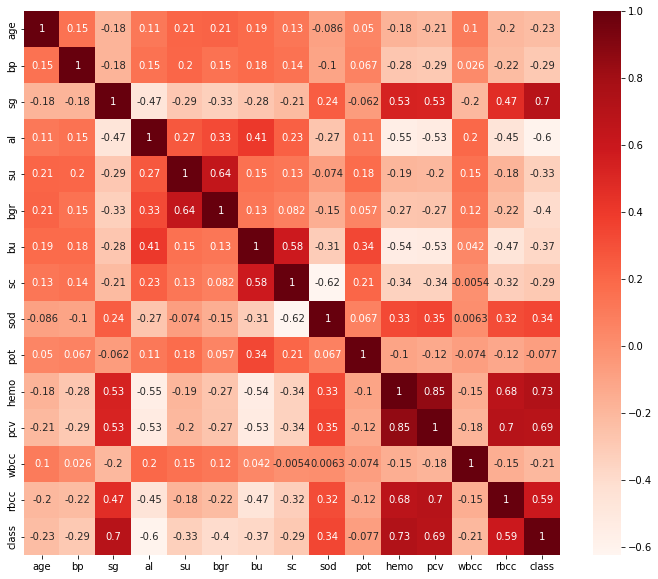

To be removedpcv
           sg        al      hemo          rbcc  htn  appet
0    0.483355 -0.013338  1.059271  5.869017e-01  1.0    0.0
1    0.483355  2.347516 -0.452097 -1.058283e-15  0.0    0.0
2   -1.381391  0.773613 -1.078762 -1.058283e-15  0.0    1.0
3   -2.313764  2.347516 -0.488960 -9.620759e-01  1.0    1.0
4   -1.381391  0.773613 -0.341509 -1.280110e-01  0.0    0.0
..        ...       ...       ...           ...  ...    ...
395  0.483355 -0.800290  1.169859  2.294454e-01  0.0    0.0
396  1.415727 -0.800290  1.464760  1.778423e+00  0.0    0.0
397  0.483355 -0.800290  1.206722  8.252060e-01  0.0    0.0
398  1.415727 -0.800290  0.616920  1.420967e+00  0.0    0.0
399  1.415727 -0.800290  1.206722  1.659271e+00  0.0    0.0

[400 rows x 6 columns]
score : 0.9696969696969697
           sg        al      hemo          rbcc  htn  appet
0    0.483355 -0.013338  1.059271  5.869017e-01  1.0    0.0
1    0.483355  2.347516 -0.452097 -1.058283e-15  0.0    0.0
2   -1.381391  0.773613 -1.07876

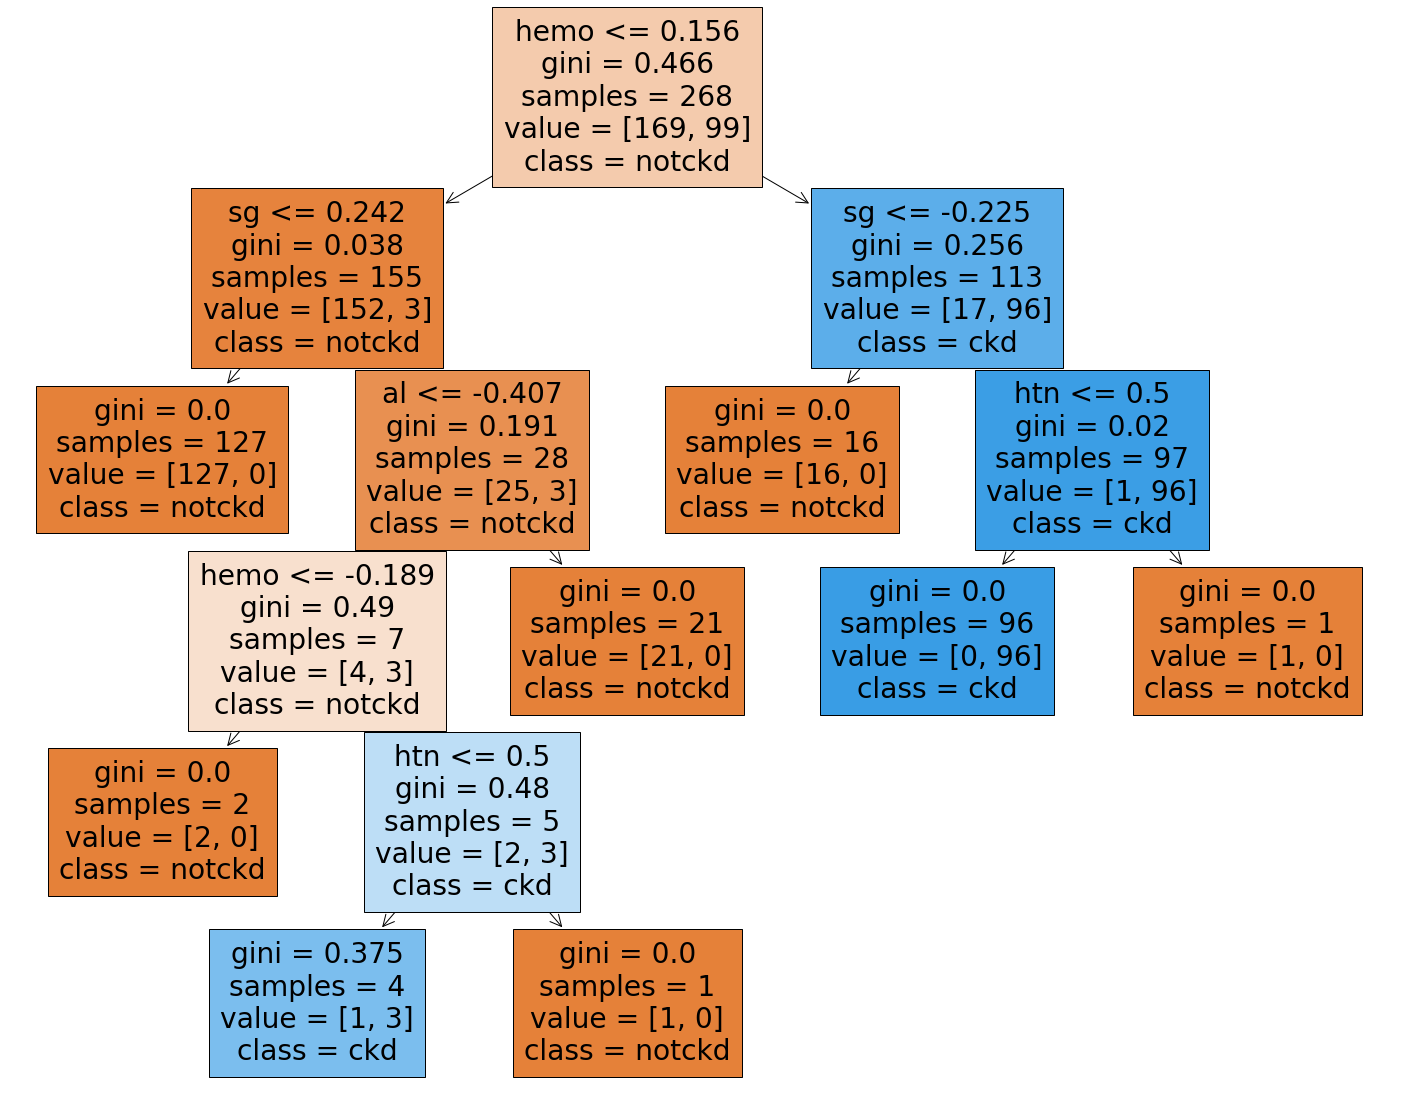

In [ ]:
import pandas as pd
import numpy as np
#Missing Data fill
from sklearn.impute import SimpleImputer
#For nominal Data encoding to numerical values:
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Nominal Feature reduction:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
#For Heatmap visualisation:
import seaborn as sns
import matplotlib.pyplot as plt
#To split dataset into training and testing:
from sklearn.model_selection import train_test_split
#We use Decision tree for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Threshold for corr between intra Independent attributes
intra_attribute_thresh = 0.8
#Threshold for corr between Independent attribute and target
target_attr_thresh = 0.5
#Number of nominal attributes to be selected in SelectKBest
k_nominal = 2


def pre_process_data(raw_DF):
    """
    In the given Dataframe, we observe that there are numerous entries which do not have values along some columns.
    We also see that there are multiple attributes (columns) which might increase dimension of the problem unnecessarily.
    Finally, we also see that there are numerous entries (rows). Usually, you might think that more the number of entries, better is the model trained.
    However, here I have an opinion. If you see, this is a classification problem which will eventually construct Decision trees which will predict the output of an entry tuple.
    Now, the efficiency of a decision tree is determined by Gini Index which is how efficiently we split the data into two branches at a given node (node is the attribute which based on which we split the data)
    If we have 5 entries of the same type, it may skew the split and this the Gini Index will get affected.
    
    We first fill the missing values
    .
    Then we do dimensionality reduction
    .
    Then we do data reduction

    The reason we do dimensionality reduction prior to data reduction is just to ensure that correlation between the attributes is provided using ALL the entries in the given dataset
    """
    #While filling the missing values we should ensure that we are doing this separately for numerical and nominal attributes
    #Please check the 'strategy' parameter at https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html to understand how we are going to fill the missing values.
    
    """
    #find the datatypes in the given pandas dataset:
    print(raw_DF.dtypes)
    #below would filter all the non numeric data if df.dtypes gave good output which is not the case here.
    df_nominal = df.loc[:,df.dtypes==np.object]
    """
    
    #First, let us replace the missing values by a common value which should be np.nan as given in above referred weblink:
    raw_DF.replace(['?', '?\t', '\t?'], np.nan, inplace=True)

    #Now, we separate out the nominal and numeric attributes in the dataset manually:
    #NOTE: For ORDINAL data, [al, su], we add them with numerical data itself. Finally, we are planning to normaliza the entire numeric data, so they will be handled accordingly
    numerical_columns = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']      #['age', 'bp',  'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
    nominal_columns = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane','class']                       #['sg','al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad','appet', 'pe', 'ane', 'class']

    #Now, we fill the missing values, (which are now NaN), with meaningful data based on mean/median/mode/ost frequent etc.
    #We fill the Dataframe with these values with the help of something called as the transformer in sci-kit learn. [reference:https://www.section.io/engineering-education/custom-transformer/ another insightful video: https://youtu.be/BotYLBQfd5M]
    #We use the already available SimpleImputer transformer to transform our data.[https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html]
    #Here, we create an object of the transformer.

    #for the nominal data, we want to replace missing values with most frequent nominal value:
    imputer_nominal = SimpleImputer(strategy="most_frequent")
    #For numeric data, we want to replace missing values with mean value of that attribute:
    imputer_numeric = SimpleImputer(strategy='mean')

    #From https://www.section.io/engineering-education/custom-transformer/ you must have noticed that every transformer has a fit_transform method inbuilt in it.
    #We use this to transform our data with missing values to meaningful data.
    raw_DF[nominal_columns] = imputer_nominal.fit_transform(raw_DF[nominal_columns])
    raw_DF[numerical_columns] = imputer_numeric.fit_transform(raw_DF[numerical_columns])

    ##########This completes the first step of filling missing values###########
    ##########    Now we go for dimensionality reduction            ############        ##We did not
    #Before we go to dimensionality reduction, we will first encode nominal attributes to numbers.
    labelencoder = LabelEncoder()
    raw_DF[nominal_columns] = raw_DF[nominal_columns].apply(labelencoder.fit_transform)
    raw_DF = raw_DF.astype(float)
    #We will also normalize the numerical data to have mean=0 and variance=1 here.
    #TODO: Practically, we split the training and testing data before normalizing the Dataset.
    #Actually the fit_transform methos is used only on training data. This will generate the mean and std dev for the training data only.
    #Based on the Mean and stddev of training data, we normalize the test data (Precisely, test data should not affect the mean and stddev we calculate)
    #Here, due to time constraints, however we will take mean and stddev of entire DS
    scaler = StandardScaler()
    raw_DF[numerical_columns] = scaler.fit_transform(raw_DF[numerical_columns])
    raw_DF = raw_DF.astype(float)

    #Nominal Attribute
    #Dimensionality reduction with Nominal data is an interesting concept. I would request you to take a look at [https://stats.stackexchange.com/a/360349]
    #Note, after reading above discussion, note that we are going for Feature Selection (FS) We are mostly looking at chi-square
    #split the dataframe into Independent attributes and dependent (target) variable:
    #X = nominal_DF.drop(['class'], axis = 1)
    nominal_DF = raw_DF[nominal_columns]
    nominal_DF_X = nominal_DF.drop(['class'], axis = 1)
    y = raw_DF['class']
    #Similar to transformer, this is also a preprocessing transformer. Thus, create its object
    selector = SelectKBest(score_func=chi2, k=k_nominal)
    #initially just use the fit command to only calculate CHI2 values for the column
    selector.fit(nominal_DF_X, y)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    nominal_df_reduced = nominal_DF_X.iloc[:,cols]

    #Numeric Attribute
    Numeric_DF_X = raw_DF[numerical_columns]            #Numeric does not have dependent attribute so no need to drop
    #NOTE, we find correlation of Numeric_DF with target first. Thus, we will have value of correlation of each feature with the target
    #From https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b, you will see that we use Pearson coefficient.
    #From above you will also see that the Attributes should be independent of each other.
    #Thus, we need to find correlsation between two attributes as well.
    #If abs(correlation) is high between two attributes, we need to drop either one.
    #Which one to be dropped will be decided by abs(correlation between the attribute and the target). Higher the said correlation, more are the chances of that attribute to be reatined

    #LEt us also append the target to Numeric_DF_X.
    Numeric_DF = Numeric_DF_X.join(y)
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html is a method in Pandas which gives pairwise (Column to Column) calculation of correlation.
    cor = Numeric_DF.corr()
    #print("Printing cor")
    #print(cor)
    #Visualisation things
    plt.figure(figsize=(12,10))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

    #Now we select the correlation between which two things is needed.
    #first we do correlation between each feature and target
    cor_target = abs(cor["class"])      #correlation with target (class attribute in our DS) should be greater than 0.5
    relevant_features_with_cor = cor_target[cor_target>target_attr_thresh]
    #print(relevant_features_with_cor)
    #Here we have all the features in numerical data for which correlation with target is high.
    #Now, we still see that some of these features like hemo and pcv have very high correlation among themselves.
    #So, let us use the correlation matrix cor to find such pairs.
    #First, let us create a DF out of the relevant features
    relevant_features = list(relevant_features_with_cor.index)
    numeric_df_reduced = Numeric_DF[relevant_features]
    #We drop dependent attribute again from this as we are looking at intra-independent attributes
    numeric_df_reduced = numeric_df_reduced.drop(['class'], axis = 1)
    #print(numeric_df_reduced)

    #Now, we again find the correlation between the reduced attributes:
    cor2 = numeric_df_reduced.corr()
    #Since the correlation matrix is symmetric along the diagonal, we only need to find correlations upto middle attribute.
    #Number of attributes in numeric_df_reduced
    attributes = list(numeric_df_reduced)
    nclmn = len(attributes)
    n = int((nclmn + 1)/2)
    #create a set in python to hold all the final selected numeric attributes
    #final_Numeric_attr = set()
    attr_list_to_remove = set()
    #TODO: Use Hash tables to optimize this
    for i in range(0,n):
        cor2_attr = abs(cor2[attributes[i]])
        matching_attr_with_cor = cor2_attr[cor2_attr>intra_attribute_thresh]       #Attributes with more than 80% correlation should be said as matching
        #print(matching_attr_with_core)
        matching_attr = list(matching_attr_with_cor.index)
        
        #Extract the target corr of all the matching attributes
        target_corr = relevant_features_with_cor[matching_attr]
        #actually this is not the right way. We need find the attributes which should be dropped instead of finding which ones to select.
        #final_Numeric_attr.add(target_corr.idxmax())
        while (len(matching_attr) > 1):
            #find the attribute which has minimum corr with target
            attr_to_remove = target_corr.idxmin()
            matching_attr.remove(attr_to_remove)
            attr_list_to_remove.add(attr_to_remove)
    print("To be removed" + str(attr_to_remove))
    final_Numeric_DF = numeric_df_reduced.drop(attr_list_to_remove, axis = 1)
    #final_Numeric_DF = numeric_df_reduced[final_Numeric_attr]

    #combine Numerical attributes and Nominal Attributes
    Preprocessed_DF_X = pd.concat([final_Numeric_DF, nominal_df_reduced], axis=1)
    #Preprocessed_DF = pd.concat(Preprocessed_DF_X, y ,axis=1)
    #print(Preprocessed_DF_X)
    return Preprocessed_DF_X, y

# Train the classifier model
def train_classifier(Preprocessed_DF_X, y):

    # Split the dataset for training an testing
    x_train, x_test, y_train, y_test = train_test_split(Preprocessed_DF_X, y, test_size=0.33)

    # Train the classifier
    dt = DecisionTreeClassifier(random_state = 0)
    dt.fit(x_train,y_train)
    print("score :",dt.score(x_test,y_test))

    return dt
    
def plot_decision_tree(dt, features):

    classes = ['notckd', 'ckd']

    # Print the tree to console in text form 
    tree_text = tree.export_text(dt, feature_names = features)
    print(tree_text)

    # Plot the tree and save it
    fig = plt.figure(figsize=(25,20))
    my_tree = tree.plot_tree(dt, feature_names = features, class_names = classes, filled = True)
    fig.savefig("decision_tree.png")


if __name__ == "__main__":
    raw_DF = pd.read_csv('sample_data/kidneyChronic.csv')
    Preprocessed_DF_X, y = pre_process_data(raw_DF)
    print(Preprocessed_DF_X)

    #pre_processed_df = pre_process_data(data)
    decision_tree = train_classifier(Preprocessed_DF_X, y)
    print(Preprocessed_DF_X)
    features = list(Preprocessed_DF_X)
    plot_decision_tree(decision_tree, features)